<a href="https://colab.research.google.com/github/EgorSolovei/VK-recommendation-system/blob/main/create_user_movie_matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Idea

1. Создаём 3 матрицы: 
- 1: матрица рейтингов, где стока матрицы - это оценки каждого userID, а столбец - оценки каждого movieId. Размер: (количество userID х количество movieId)
- 2: матрица профилей userID. Где каждый профиль описывается К признаками. Размер: (количество userID х К)
- 3: матрица профиля movieId. Каждый профиль описывается К признаками. Размер: (К х количество movieId)

2. Нейронная сеть будет иметь такую архетектуру: 
- на выходе мы будем получать скалярное произведение векторов профиля пользователя и профиля фильма, что и будет нашим предсказанным рейтингом в матрице рейтингов: $y_{ij} = (w_i \vec{u_i}, t_j \vec{m_j})$, где 
$\vec{u_i}$ - i вектор профиля пользователя,  $\vec{m_j}$ - j вектор профиля фильма, а $w_i, t_j$ - веса нейронной сети для профиля пользователя и фильма соответственно.  

# Filtering

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
ratings = pd.read_csv('ratings.csv') # самый жирный файл

In [ ]:
ratings.drop(columns=['timestamp'], inplace=True)
ratings.head()

,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5


In [ ]:
# не хватит памяти, чтобы построить матрицу таких размеров, поэтому нужно убрать малоинформативные профили
ratings.movieId.unique().shape, ratings.userId.unique().shape # количество фильмов и пользователей

((53889,), (283228,))

In [ ]:
# будем выбирать такие профили пользователей, которые поставили хотя бы 30 оценок
ratings.groupby('userId')['movieId'].count().reset_index(name='count_film').describe()

,userId,count_film
count,283228.000000,283228.000000
mean,141614.500000,97.989761
std,81761.025358,212.760722
min,1.000000,1.000000
25%,70807.750000,15.000000
50%,141614.500000,30.000000
75%,212421.250000,95.000000
max,283228.000000,23715.000000


In [ ]:
# будем выбирать такие профили фильмов, которые имеют хотя бы 46 оценок
ratings.groupby('movieId')['userId'].count().reset_index(name='count_score').describe()

,movieId,count_score
count,53889.000000,53889.000000
mean,109110.137950,515.011301
std,60910.551686,2934.758939
min,1.000000,1.000000
25%,66310.000000,2.000000
50%,123105.000000,7.000000
75%,160770.000000,48.000000
max,193886.000000,97999.000000


In [ ]:
# фильтруем данные
user_movie_df = ratings.groupby('userId').filter(lambda x: len(x) >= 30)\
                        .groupby('movieId').filter(lambda x: len(x) >= 46).reset_index()

user_movie_df.drop(columns='index', inplace=True)
user_movie_df.head()

,userId,movieId,rating
0,4,1,4.0
1,4,2,4.0
2,4,5,2.0
3,4,6,4.5
4,4,10,4.0


In [ ]:
user_movie_df.movieId.unique().shape, user_movie_df.userId.unique().shape # количество фильмов и пользователей

((13627,), (143545,))

In [ ]:
user_movie_df.memory_usage(index=True).sum() / 1048576 # мб занимает этот массив

583.6403121948242

In [ ]:
user_movie_df.shape

(25499629, 3)

In [ ]:
user_movie_df.groupby('userId')['movieId'].count().reset_index(name='count_film').describe()

,userId,count_film
count,143545.000000,143545.000000
mean,141881.558306,177.642056
std,81696.681107,257.885642
min,4.000000,6.000000
25%,71042.000000,51.000000
50%,142211.000000,93.000000
75%,212549.000000,195.000000
max,283228.000000,9560.000000


In [ ]:
user_movie_df.groupby('movieId')['userId'].count().reset_index(name='count_score').describe()

,movieId,count_score
count,13627.000000,13627.000000
mean,41960.801644,1871.257724
std,49920.389059,5026.778958
min,1.000000,46.000000
25%,3811.500000,105.000000
50%,8334.000000,308.000000
75%,73597.500000,1236.500000
max,192307.000000,80879.000000


In [ ]:
user_movie_df.to_csv('user_movie_raw.csv') # отфильтрованные данные rating. Пригодятся для создания признаков user и movie
!cp user_movie_raw.csv "/content/drive/MyDrive/Colab_Notebooks/ML_&_AI/Pratice/NN/VK recomd/data"

# Create matrix 


Преобразовать в один массив не получилось с помощью библиотек - не хватает оперативной памяти. Поэтому будем делать в лоб - создавать отдельный вектора для каждого пользователя и по индексу фильма ставить оценку этого пользователя (изначально создаётся нулевой вектор). Считать эту матрицу придётся долго, порядка 8 часов.

In [ ]:
# создадим нужные названия колонок
col = ['userId']
for movie_id in list(user_movie_df.movieId.unique()):
    col.append(f'{movie_id}')

user_movie = pd.DataFrame(columns=col)

In [ ]:
del ratings

In [ ]:
count = 0
for user_id in list(user_movie_df.userId.unique()):
    user_vec = pd.Series([0] * 13628, index=col)
    user_vec.userId = user_id

    data_temp = user_movie_df[user_movie_df['userId'] == user_id]
    # data_temp.drop(columns='userId', inplace=True) # может потом

    for movie_id in data_temp['movieId'].values:
        user_vec[f'{movie_id}']  = data_temp[data_temp['movieId'] == movie_id]['rating'].values[0]
    user_vec = user_vec.astype('float16')

    user_movie.loc[len(user_movie.index)] = user_vec # добавление вектора в конец DataFrame user_movie

    count += 1
    if count % 5000 == 0:
        print(f'Построено {count} профилей пользователей')
        print(f'Размер матрицы user_movie: {user_movie.memory_usage(index=True).sum() / 1048576} мб')

In [ ]:
user_movie = user_movie.astype({'userId': 'int32'})
user_movie

,userId,1,2,5,6,10,11,16,19,20,...,47868,103449,69498,130044,819,6499,166149,6588,87549,4955
0,4,4.0,4.0,2.0,4.5,4.0,3.5,4.0,2.0,2.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30024,59616,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30025,59616,4.5,2.5,0.0,4.0,2.0,0.0,4.0,2.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30026,59616,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30027,59616,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
user_movie.to_csv('user_movie.csv')
!cp user_movie.csv "/content/drive/MyDrive/Colab_Notebooks/ML_&_AI/Pratice/NN/VK recomd/data"

# EmbeddingDotBias Model

In [ ]:

import fastai.collab as fai

data = fai.CollabDataLoaders.from_df(ratings, seed=42, valid_pct=0.1, user_name='userId', item_name='movieId', rating_name='rating')

In [ ]:
data.show_batch()

,userId,movieId,rating
0,31513,27772,3.0
1,191923,33794,4.5
2,173229,480,4.0
3,190340,1220,4.5
4,89364,208,2.5
5,111468,236,3.5
6,172032,7024,0.5
7,150762,1894,4.0
8,112163,368,5.0
9,216848,4571,3.0


In [ ]:
ratings.rating.min(), ratings.rating.max()

(0.5, 5.0)

In [ ]:
learn = fai.collab_learner(data, n_factors=40, y_range=(0.5, 5.0), wd=1e-1)
learn.summary()

EmbeddingDotBias (Input shape: 64 x 2)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 40             
Embedding                                 11304080   True      
Embedding                                 2112160    True      
____________________________________________________________________________
                     64 x 1              
Embedding                                 282602     True      
Embedding                                 52804      True      
____________________________________________________________________________

Total params: 13,751,646
Total trainable params: 13,751,646
Total non-trainable params: 0

Optimizer used: <function Adam at 0x7f5c116ddf30>
Loss function: FlattenedLoss of MSELoss()

Callbacks:
  - TrainEvalCallback
  - CastToTensor
  - Recorder
  - ProgressCallback

SuggestedLRs(valley=0.25118863582611084)

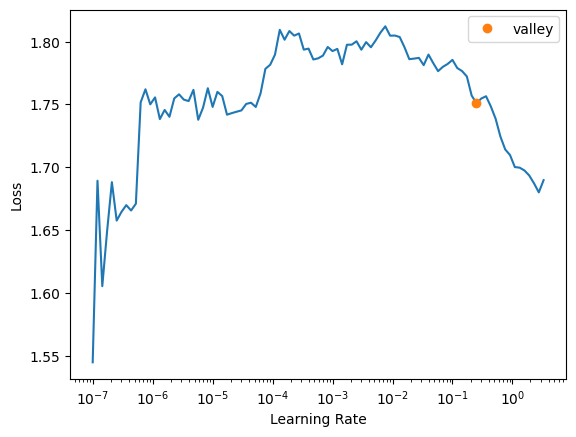

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(1, 0.25) # будет считать очень долго и не вижу смыслы

epoch,train_loss,valid_loss,time


KeyboardInterrupt: ignored